# Independence testing
## First, make a simulation again:

In [ ]:
import time
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
#from scipy.stats import chi2_contingency
from statsmodels.stats.contingency_tables import Table2x2
from statsmodels.stats.multitest import multipletests
from scipy.special import erf
from lifelines import KaplanMeierFitter
from lifelines import CoxTimeVaryingFitter

from multipathogen_sero import (
    simulate_infections,
    simulate_infections_survivor,
    simulation_to_regression_df,
    simulation_to_survey_long,
    survey_long_to_wide,
    independence_test,
    significance
)


2025-08-12 20:48:35.675 | INFO     | multipathogen_sero.config:<module>:12 - PROJ_ROOT path is: /home/ayan/sero/multipathogen-sero


In [2]:
# baseline hazards / survivor functions

def get_gaussian_foi(mu,sigma,a):
    """Generate a Gaussian function for the force of infection."""
    return lambda t: np.exp(-((t - mu) ** 2) / (2 * sigma ** 2)) * a
def get_exponential_foi(lam, a):
    """Generate an exponential function for the force of infection."""
    return lambda t: np.exp(-lam * t) * a
def get_gaussian_survivor(mu, sigma, a):
    norm = a * sigma * np.sqrt(np.pi / 2)
    def S(t):
        return np.exp(
            -norm * (erf((t - mu) / (np.sqrt(2) * sigma)) - erf((-mu) / (np.sqrt(2) * sigma)))
        )
    return S
def get_exponential_survivor(lam, a):
    def S(t):
        return np.exp(-a * (1 - np.exp(-lam * t)) / lam)
    return S

In [3]:
n_people = 10000 #number of individuals n
np.random.seed(42)  # For reproducibility
birth_times = np.random.uniform(0, 100, size=n_people)  # Random birth times for individuals
n_pathogens=12 #number of pathogens K
t_max=100
pathogen_names = [f'Pathogen {i+1}' for i in range(n_pathogens)]  # Names for pathogens
#foi_list = [get_exponential_foi(0, 1) for k, pathogen_name in enumerate(pathogen_names)]
foi_list = [
    get_gaussian_foi(mu=10*k, sigma=30, a=0.05) for k in range(n_pathogens)
]
survivor_list = [
    get_gaussian_survivor(mu=10*k, sigma=30, a=0.05) for k in range(n_pathogens)
]

# spike and slab on each coefficient of the interaction matrix
np.random.seed(42)  # For reproducibility
interaction_indicator = np.random.binomial(1, 0.1, size=(n_pathogens, n_pathogens))
interaction_indicator[np.arange(n_pathogens), np.arange(n_pathogens)] = 0
interaction_mat = np.exp(
    np.random.normal(0, 1, size=(n_pathogens, n_pathogens)) * interaction_indicator
)

In [4]:
start = time.time()
simulate_infections_df = simulate_infections(n_people, n_pathogens, foi_list, interaction_mat, t_max=t_max, birth_times=birth_times, random_seed=42)
print(f"simulate_infections took {time.time() - start:.3f} seconds")

survey_df_long = simulation_to_survey_long(
    simulate_infections_df,
    survey_times=100
)
survey_df_wide = survey_long_to_wide(survey_df_long)

simulate_infections took 3.333 seconds


## A naive independence test

Number of individuals born between 30 and 31: 97


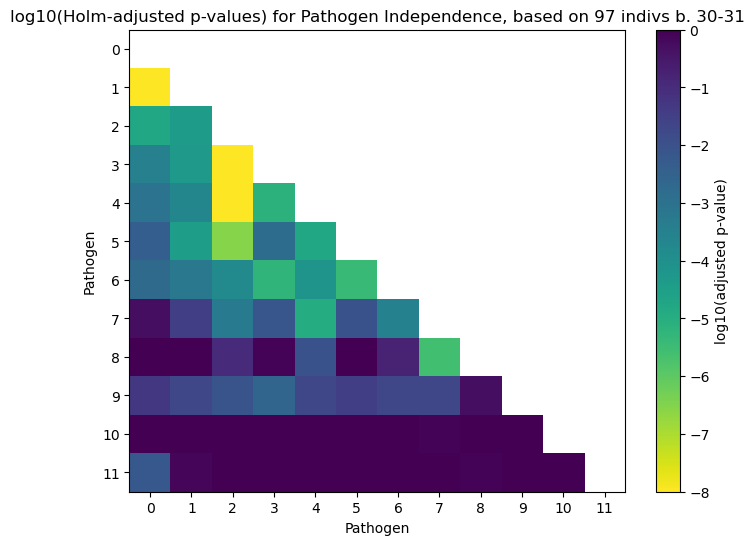

In [5]:
birth_time_lower = 30
birth_time_upper = 31
individuals_in_bin = np.where(
    (birth_times >= birth_time_lower) & (birth_times < birth_time_upper)
)[0]
print(f"Number of individuals born between {birth_time_lower} and {birth_time_upper}: {len(individuals_in_bin)}")
filtered_survey = survey_df_long[survey_df_long['individual'].isin(individuals_in_bin)]
filtered_survey_wide = survey_long_to_wide(filtered_survey)


# Collect all off-diagonal p-values
pvals = []
indices = []
for k1 in range(n_pathogens):
    for k2 in range(k1 + 1, n_pathogens):
        contingency_table = pd.crosstab(
            filtered_survey_wide[f'serostatus_{k1+1}'],
            filtered_survey_wide[f'serostatus_{k2+1}']
        )
        contingency_table = contingency_table.reindex(index=[0, 1], columns=[0, 1], fill_value=0)
        tbl = Table2x2(contingency_table)
        p_value = tbl.test_nominal_association().pvalue
        pvals.append(p_value)
        indices.append((k1, k2))

# Holm correction
_, pvals_holm, _, _ = multipletests(pvals, method='holm')

# Fill adjusted p-values into a matrix (symmetric)
pval_matrix_adj = np.ones((n_pathogens, n_pathogens))
for (k1, k2), adj_p in zip(indices, pvals_holm):
    pval_matrix_adj[k1, k2] = adj_p
    pval_matrix_adj[k2, k1] = adj_p

# Clip for plotting
pval_matrix_adj_clipped = np.clip(pval_matrix_adj, 1e-8, 1)

mask = np.triu(np.ones_like(pval_matrix_adj_clipped, dtype=bool), k=0)  # k=0 masks diagonal too
masked_matrix = np.ma.masked_where(mask, np.log10(pval_matrix_adj_clipped))

plt.figure(figsize=(8, 6))
im = plt.imshow(masked_matrix, cmap='viridis_r', aspect='auto', vmin=-8, vmax=0)
plt.colorbar(im, label='log10(adjusted p-value)')
plt.title(f'log10(Holm-adjusted p-values) for Pathogen Independence, based on {len(individuals_in_bin)} indivs b. {birth_time_lower}-{birth_time_upper}')
plt.xlabel('Pathogen')
plt.ylabel('Pathogen')
plt.xticks(np.arange(n_pathogens), np.arange(n_pathogens))
plt.yticks(np.arange(n_pathogens), np.arange(n_pathogens))
plt.show()

0.47894278388630473
0.7263565716223678
0.5914644243943188
0.48398855932991725
0.8967662778011535
0.6251848217978582
0.05680500704810865
0.8230654371258692
0.8197449779943858
0.08506432029569377
0.9471692174507269
0.6187741964046194
0.16180161081036526
0.9424708763499601
0.05797216874124089
0.3316432081348457
0.23876035173004606
0.6535950136747378
0.6282790669073499


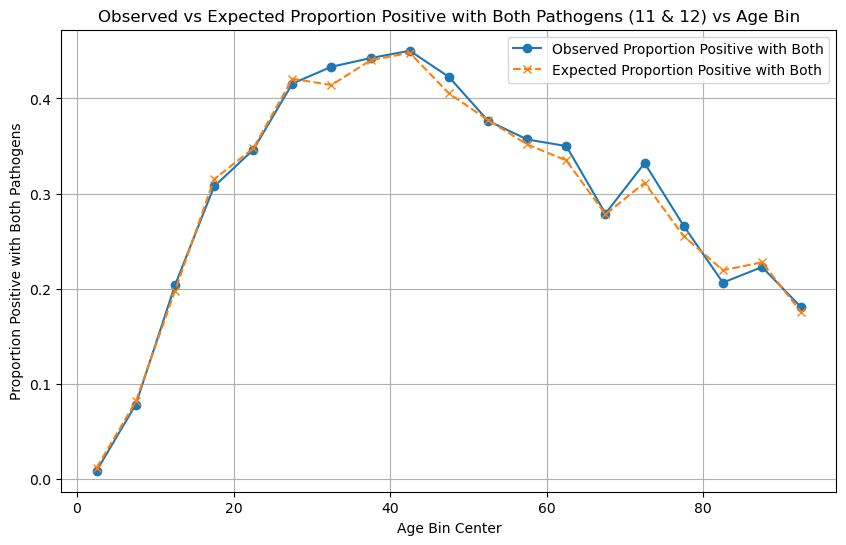

In [ ]:
k1, k2 = 11,12  # Pathogen indices to compare, 1-indexed
age_bins= np.arange(0, 100, 5)  # Define birth_year bins
# Precompute birth times for all individuals
individual_birth_times = survey_df_wide.merge(
    pd.DataFrame({'individual': np.arange(1,len(birth_times)+1), 'birth_time': birth_times}),
    on='individual'
)
individual_birth_times["age"] = t_max - individual_birth_times["birth_time"]

age_bin_results = []

for bin_idx in range(len(age_bins) - 1):
    lower_bound = age_bins[bin_idx]
    upper_bound = age_bins[bin_idx + 1]
    in_bin = (individual_birth_times['age'] >= lower_bound) & (individual_birth_times['age'] < upper_bound)
    filtered = individual_birth_times[in_bin]
    
    p_value, observed_proportion, expected_proportion = independence_test(
        filtered[f'serostatus_{k1}'], filtered[f'serostatus_{k2}']
    )
    age_bin_results.append((lower_bound, upper_bound, p_value, observed_proportion, expected_proportion))
age_bin_results_df = pd.DataFrame(age_bin_results, columns=['lower_bound', 'upper_bound', 'p_value', 'observed_proportion', 'expected_proportion'])
age_bin_results_df['bin_midpoint'] = (age_bin_results_df['lower_bound'] + age_bin_results_df['upper_bound']) / 2

# Plot observed and expected proportions against age bins
plt.figure(figsize=(10, 6))
plt.plot(age_bin_results_df['bin_midpoint'], age_bin_results_df['observed_proportion'], marker='o', linestyle='-', label='Observed Proportion Positive with Both')
plt.plot(age_bin_results_df['bin_midpoint'], age_bin_results_df['expected_proportion'], marker='x', linestyle='--', label='Expected Proportion Positive with Both')

# Add asterisks for p-values
for row in age_bin_results_df.itertuples():
    p_value = row.p_value
    if not np.isnan(p_value):
        asterisks = significance(p_value)
        if asterisks:
            plt.text(row.bin_midpoint, -0.05, asterisks, ha='center', va='bottom', fontsize=10, color='red')

plt.xlabel('Age Bin Center')
plt.ylabel('Proportion Positive with Both Pathogens')
plt.title(f'Observed vs Expected Proportion Positive with Both Pathogens ({k1} & {k2}) vs Age Bin')
plt.grid(True)
plt.legend()
plt.show()

/tmp/ipykernel_1237784/1538339599.py:45: RuntimeWarning: divide by zero encountered in log10
  log_pval_matrix = np.log10(pval_matrix)


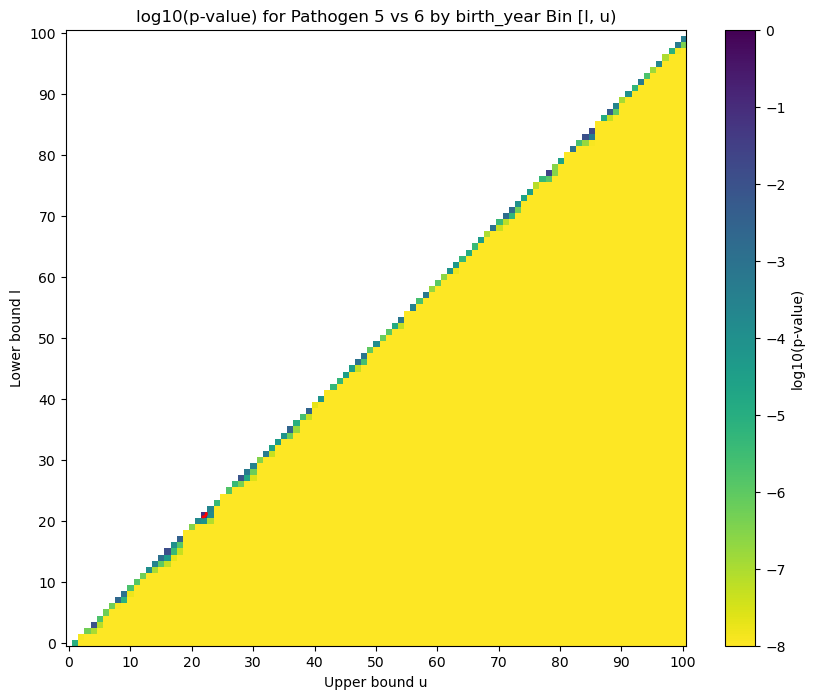

In [37]:
k1, k2 = 5,6  # Pathogen indices to compare
max_birth_year = int(np.ceil(birth_times.max()))
min_birth_year = int(np.floor(birth_times.min()))
heatmap_size = max_birth_year - min_birth_year + 1

# Convert once to wide format
survey_df_wide = survey_long_to_wide(survey_df_long)

# Precompute birth times for all individuals
individual_birth_times = survey_df_wide.merge(
    pd.DataFrame({'individual': np.arange(len(birth_times)), 'birth_time': birth_times}),
    on='individual'
)

# Precompute contingency tables for each [t, t+1) bin
contingency_tables = []
for t in range(min_birth_year, max_birth_year):
    in_bin = (individual_birth_times['birth_time'] >= t) & (individual_birth_times['birth_time'] < t + 1)
    filtered = individual_birth_times[in_bin]
    if (f'serostatus_{k1}' in filtered.columns and
        f'serostatus_{k2}' in filtered.columns and
        filtered[f'serostatus_{k1}'].nunique() > 1 and
        filtered[f'serostatus_{k2}'].nunique() > 1):
        ct = pd.crosstab(filtered[f'serostatus_{k1}'], filtered[f'serostatus_{k2}'])
        # Ensure 2x2 shape for summing later
        ct = ct.reindex(index=[0,1], columns=[0,1], fill_value=0)
        contingency_tables.append(ct.values)
    else:
        contingency_tables.append(np.zeros((2,2), dtype=int))


pval_matrix = np.full((heatmap_size, heatmap_size), np.nan)

# Efficiently sum contingency tables for each [l, u) bin
for l in range(min_birth_year, max_birth_year):
    cumsum = np.zeros((2,2), dtype=int)
    for u in range(l + 1, max_birth_year + 1):
        cumsum += contingency_tables[u - min_birth_year - 1]  # [l, u): add bin u-1
        if cumsum.sum() < 5 or np.any(cumsum.sum(axis=0) == 0) or np.any(cumsum.sum(axis=1) == 0):
            continue
        tbl = Table2x2(cumsum)
        p_value = tbl.test_nominal_association().pvalue
        pval_matrix[l - min_birth_year, u - min_birth_year] = p_value

log_pval_matrix = np.log10(pval_matrix)
log_pval_matrix_clipped = np.where(np.isnan(log_pval_matrix), np.nan, np.maximum(log_pval_matrix, -8))

plt.figure(figsize=(10, 8))
im = plt.imshow(log_pval_matrix_clipped, origin='lower', aspect='auto', cmap='viridis_r', vmin=-8, vmax=0)
plt.colorbar(im, label='log10(p-value)')
plt.xlabel('Upper bound u')
plt.ylabel('Lower bound l')
plt.title(f'log10(p-value) for Pathogen {k1} vs {k2} by birth_year Bin [l, u)')

# Draw contour for p = 0.05
from matplotlib import ticker
X, Y = np.meshgrid(np.arange(pval_matrix.shape[1]), np.arange(pval_matrix.shape[0]))
contour = plt.contour(
    X, Y, pval_matrix, levels=[0.05], colors='red', linewidths=2, origin='lower'
)
plt.clabel(contour, fmt={0.05: 'p=0.05'}, colors='red', fontsize=10)

# Ticks every 10 years
tick_step = 10
xtick_locs = np.arange(0, heatmap_size, tick_step)
ytick_locs = np.arange(0, heatmap_size, tick_step)
plt.xticks(xtick_locs, (min_birth_year + xtick_locs).astype(int))
plt.yticks(ytick_locs, (min_birth_year + ytick_locs).astype(int))

plt.show()

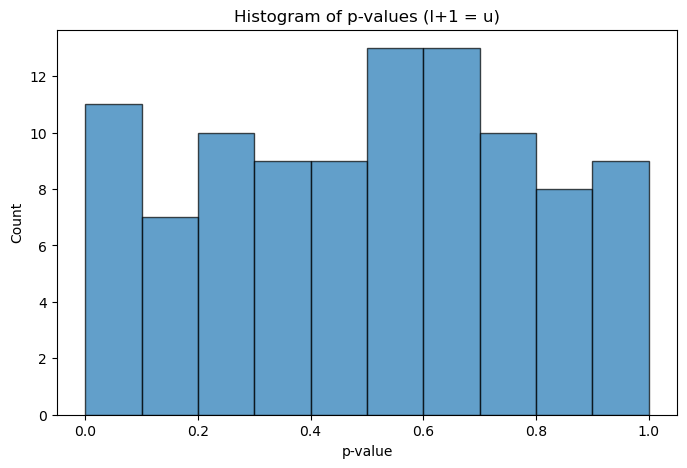

In [9]:
pvals_diag = np.diag(pval_matrix, k=1)  # k=1 gives the diagonal just above the main

# Remove NaNs
pvals_diag = pvals_diag[~np.isnan(pvals_diag)]

# Plot histogram with binwidth 0.1
plt.figure(figsize=(8, 5))
plt.hist(pvals_diag, bins=np.arange(0, 1.01, 0.1), edgecolor='black', alpha=0.7)
plt.xlabel('p-value')
plt.ylabel('Count')
plt.title('Histogram of p-values (l+1 = u)')
plt.show()